#### logistic regression

key assumptions:
* no multicollinearity
* no outliers
* large sample size
* the log-odds of dependent variableshould change linearly with changes in the independent variables.

types: <span style="color:yellow">binary </span>(win, loss) <span style="color:yellow">multinomial </span>  (a,b,c) <span style="color:yellow">ordinal </span>(low, medium,high)

see also: [sgd classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) & [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier


from sklearn.pipeline import make_pipeline

from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss, accuracy_score, \
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve 

from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [85]:
df = pd.read_csv("churn.csv")
df = df.dropna()
df.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0.0,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,0.0,No


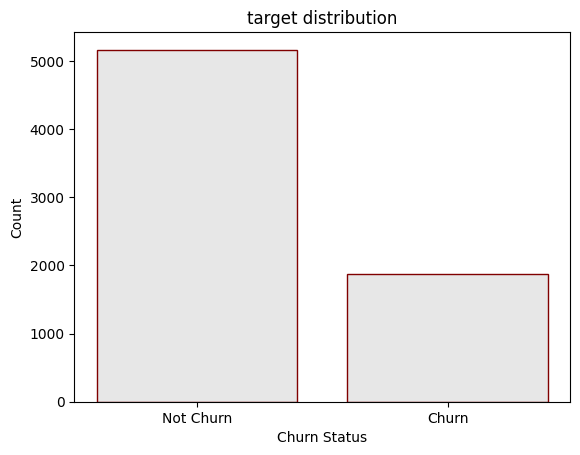

In [86]:
churn_counts = df['Churn'].value_counts()
bars = ['Not Churn', 'Churn']
height = [churn_counts[0], churn_counts[1]]

x_pos = range(len(bars))
plt.bar(x_pos, height, color=(0.1, 0.1, 0.1, 0.1), edgecolor='maroon')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks(x_pos, bars)
plt.title('target distribution')
plt.show()   

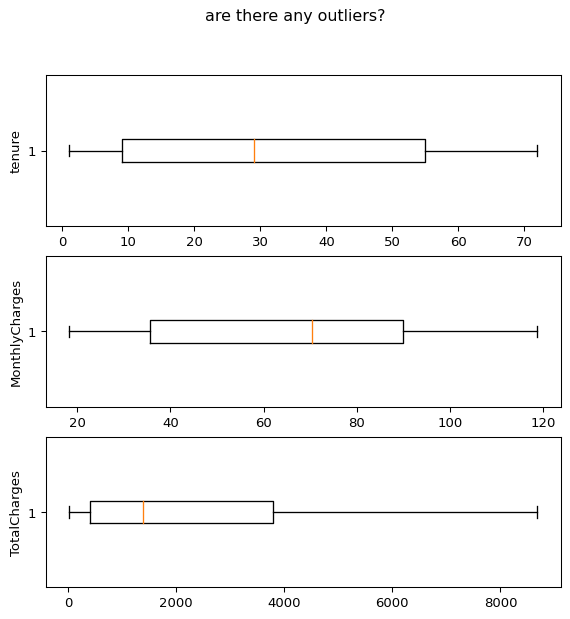

In [87]:
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
df2 = df[numerical_columns]

fig, axs = plt.subplots(3, 1, dpi=95, figsize=(7, 7))
i = 0
for col in df2.columns:
    axs[i].boxplot(df[col], vert=False)
    axs[i].set_ylabel(col)
    i += 1

plt.suptitle('are there any outliers?')
plt.show()

##### label encoding

In [88]:
X, Y = df.drop(columns = ['Churn','customerID']), df['Churn']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Y)
y = pd.Series(y)

#### deciphering the labels

In [89]:
y_encoded = label_encoder.fit_transform(Y)
mapping = dict(zip(Y, y_encoded))
for class_label, encoded_value in mapping.items():
    print(f"Original Class: {class_label} -> Encoded Value: {encoded_value}")

Original Class: No -> Encoded Value: 0
Original Class: Yes -> Encoded Value: 1


#### train/test split

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

#### transformation

sklearn: [solvers](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) || [solvers](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [91]:
column_trans = make_column_transformer (
    (OrdinalEncoder(), ['gender', 'Partner', 'Dependents', 'PhoneService','PaperlessBilling']),
    (OneHotEncoder(drop='first'), ['MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
                       'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies','Contract',
                       'PaymentMethod']),
    remainder='passthrough')

column_trans1 = make_column_transformer (
    (OrdinalEncoder(), ['gender', 'Partner', 'Dependents', 'PhoneService','PaperlessBilling']),
    (OneHotEncoder(drop='first'), ['MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
                       'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies','Contract',
                       'PaymentMethod']),
    (StandardScaler(), ['tenure','MonthlyCharges','TotalCharges','numAdminTickets','numTechTickets']),
    remainder='passthrough')


column_trans2 = make_column_transformer (
    (StandardScaler(), ['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip', 'callcard', 'wireless']),
    remainder='passthrough')

regr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5,max_iter=1000)
# regr = SGDClassifier(loss='log_loss', n_jobs=-1)

#### model fitting

In [92]:
pipe = make_pipeline(column_trans1, regr)

In [93]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'numAdminTickets',
                                                   'numTechTickets'])])),
                ('logisticregression',
                 LogisticRegression(l1_ratio=0.5, max_iter=1000,
                                    penalty='elasticnet', solver='saga'))])

#### evaluation

[Intuition behind Log-loss score](https://towardsdatascience.com/intuition-behind-log-loss-score-4e0c9979680a)

* precision - minimizing negatives incorrectly predicted as positive (fewer FP)
* recall - maximize finding and correctly classifying positive instances (fewer FN)
- raising the threshold reduces false positives - increasing precision. decrease the threshold to increase Recall


In [94]:
y_prob = pipe.predict_proba(X_test)
y_pred = pipe.predict(X_test)

print("Log Loss:", log_loss(y_test, y_prob))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Log Loss: 0.29496639019129145
Accuracy: 0.8564321250888415
Precision: 0.7521865889212828
Recall: 0.688
F1 Score: 0.7186629526462396


### jaccard index

- assesses the similarity between the predicted sets and the true sets for either class
- useful when dealing with imbalanced datasets

In [62]:
jaccard_score(y_test, y_pred,pos_label=1)

0.5584415584415584

##### classification report

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1032
           1       0.75      0.69      0.72       375

    accuracy                           0.86      1407
   macro avg       0.82      0.80      0.81      1407
weighted avg       0.85      0.86      0.85      1407



#### ROC curve (receiver operator characteristic)

[Intuition behind ROC-AUC score](https://towardsdatascience.com/intuition-behind-roc-auc-score-1456439d1f30)

- summarize the performance of a classifier over all possible probability thresholds. the more the curve is towards the top-left corner the better the model is
- the larger the area under the ROC curve (AUC), better the model is
- fpr - actual negative instances incorrectly classified as positive 
- tpr - actual positive instances correctly classified as positive/ maximize posotives

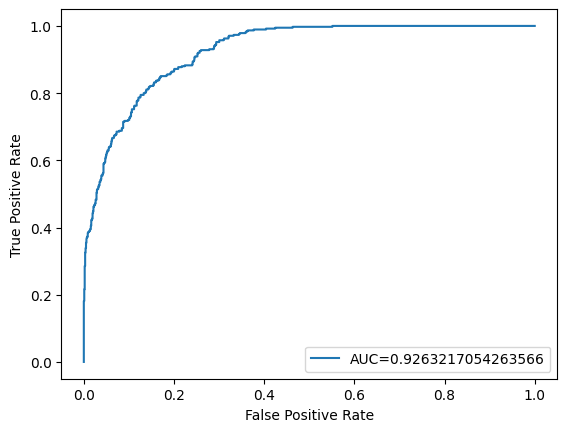

In [64]:
y_prob1 = pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_prob1)
auc = roc_auc_score(y_test, y_prob1)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

#### adjusting threshold

In [65]:
threshold = 0.4  
y_pred_custom_threshold = np.where(y_prob >= threshold, 1, 0)[::,1]
y_pred_custom_threshold

array([0, 0, 0, ..., 0, 1, 1])

#### confusion matrix

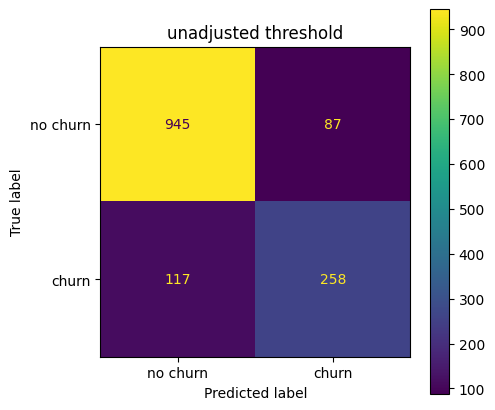

In [66]:
cm = confusion_matrix(y_test, y_pred)
mapping = {0: "no churn", 1: "churn"}  

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[mapping[i] for i in range(len(mapping))])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax)

ax.set_title("unadjusted threshold")
plt.show()

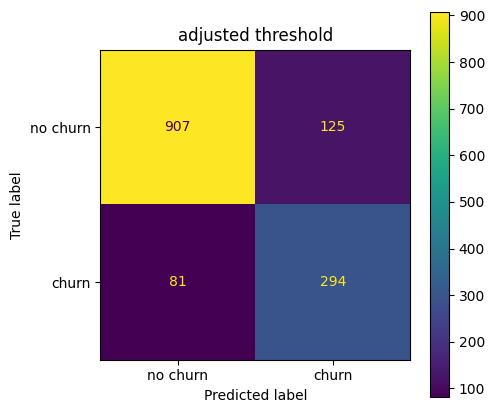

In [67]:
cm = confusion_matrix(y_test, y_pred_custom_threshold)
mapping = {0: "no churn", 1: "churn"}

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[mapping[i] for i in range(len(mapping))])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax)

ax.set_title("adjusted threshold")
plt.show()

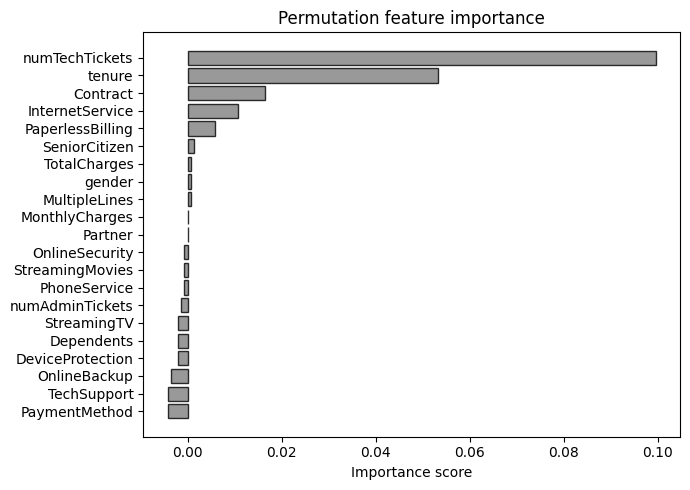

In [68]:
import rfpimp
imp = rfpimp.importances(pipe, X_test,y_test)

fig, ax = plt.subplots(figsize=(7,5))

ax.barh(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k')
# ax.stem(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k')
ax.set_xlabel('Importance score')
ax.set_title('Permutation feature importance')
# ax.text(0.8, 0.15, 'ngere', fontsize=12, ha='center', va='center',transform=ax.transAxes, color='grey', alpha=0.5)
plt.gca().invert_yaxis()

fig.tight_layout()

[decision boundary plot](https://www.javatpoint.com/logistic-regression-in-machine-learning)

#### predict

In [20]:
test = pd.read_csv('test.csv')
X = test.drop(columns = 'customerID')
X.head(1)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0


In [21]:
churn = pipe.predict(X)
churn = pd.Series(churn)
churn

0    1
1    0
2    0
3    0
4    1
5    1
6    0
7    0
dtype: int32

In [22]:
test['churn'] = churn
mapping = {1: 'Yes', 0: 'No'}
test['churn'] = test['churn'].replace(mapping)


In [23]:
test.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,Yes
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.50,0,0,No
